# Create a model from DistilBERT with no tuning

In [154]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import tensorflow as tf

import pandas as pd
import numpy as np

classifier = pipeline('sentiment-analysis')

import random
random.seed(42)

In [155]:
save_directory = "distilbert-base-uncased"
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

All PyTorch model weights were used when initializing TFDistilBertModel.

Some weights or buffers of the PyTorch model TFDistilBertModel were not initialized from the TF 2.0 model and are newly initialized: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [156]:
df = pd.read_csv('data/labeled_forum_test.csv')
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.20, random_state=42)

In [157]:
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

In [158]:
# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [159]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=30, 
          verbose=1, 
          validation_split=0.2,
         )

Train on 2591 samples, validate on 648 samples
Epoch 1/30
2591/2591 [==============================] - 152s 59ms/sample - loss: 0.7549 - acc: 0.7302 - val_loss: 0.7006 - val_acc: 0.7500
Epoch 2/30
2591/2591 [==============================] - 142s 55ms/sample - loss: 0.6811 - acc: 0.7495 - val_loss: 0.6345 - val_acc: 0.7500
Epoch 3/30
2591/2591 [==============================] - 160s 62ms/sample - loss: 0.6139 - acc: 0.7518 - val_loss: 0.5844 - val_acc: 0.7716
Epoch 4/30
2591/2591 [==============================] - 141s 54ms/sample - loss: 0.5691 - acc: 0.7684 - val_loss: 0.5637 - val_acc: 0.7824
Epoch 5/30
2591/2591 [==============================] - 143s 55ms/sample - loss: 0.5485 - acc: 0.7843 - val_loss: 0.5451 - val_acc: 0.7978
Epoch 6/30
2591/2591 [==============================] - 137s 53ms/sample - loss: 0.5270 - acc: 0.7904 - val_loss: 0.5173 - val_acc: 0.8025
Epoch 7/30
2591/2591 [==============================] - 136s 53ms/sample - loss: 0.5006 - acc: 0.7916 - val_loss: 0.509

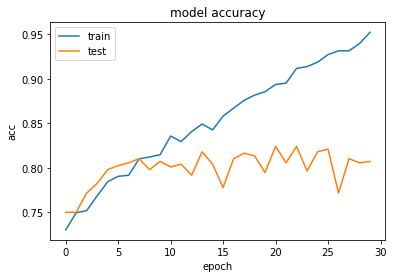

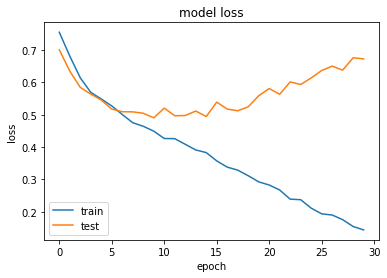

In [164]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

In [161]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)

810/810 [==============================] - 34s 42ms/sample - loss: 0.6596 - acc: 0.8049


In [162]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.659552362230089
Test Accuracy: 0.80493826


In [163]:
model.save_weights('models/final_models/bert_only/bert_only')

## best epoch is 8:
loss: 0.4752 - acc: 0.8101 - val_loss: 0.5087 - val_acc: 0.8102

In [165]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=8, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/8
2591/2591 [==============================] - 242s 93ms/sample - loss: 0.1521 - acc: 0.9452 - val_loss: 0.6486 - val_acc: 0.8009
Epoch 2/8
2591/2591 [==============================] - 244s 94ms/sample - loss: 0.1380 - acc: 0.9467 - val_loss: 0.6846 - val_acc: 0.7948
Epoch 3/8
2591/2591 [==============================] - 240s 93ms/sample - loss: 0.1284 - acc: 0.9506 - val_loss: 0.7343 - val_acc: 0.8117
Epoch 4/8
2591/2591 [==============================] - 244s 94ms/sample - loss: 0.1061 - acc: 0.9641 - val_loss: 0.7688 - val_acc: 0.7747
Epoch 5/8
2591/2591 [==============================] - 240s 93ms/sample - loss: 0.1307 - acc: 0.9525 - val_loss: 0.7685 - val_acc: 0.8117
Epoch 6/8
2591/2591 [==============================] - 194s 75ms/sample - loss: 0.1572 - acc: 0.9402 - val_loss: 0.7553 - val_acc: 0.8164
Epoch 7/8
2591/2591 [==============================] - 137s 53ms/sample - loss: 0.1148 - acc: 0.9599 - val_loss: 0.7630 - val

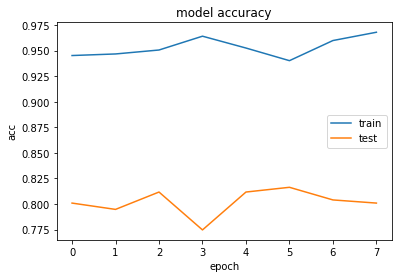

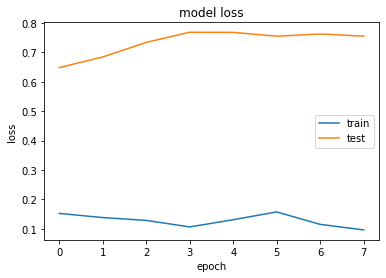

In [166]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

In [167]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

810/810 [==============================] - 30s 37ms/sample - loss: 0.7401 - acc: 0.8099
Test Score: 0.7401057767279354
Test Accuracy: 0.80987656


In [168]:
model.save_weights('models/final_models/bert_only2/bert_only2')